In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Setup

Setting things up from Phase-1 for Phase-2.  
**NOTE**: The results here are slightly different from Phase-1, thats due to some small issues with the way data was used in Phase-1. Will fix that soon

**TODO**: Phase-1 data pipeline issue, `train_df['Cycle']` is not meant to exist and be used later

In [3]:
import os
from pathlib import Path
curr_dir = Path(os.getcwd())
data_dir = curr_dir.parent.parent / "data" / "train_FD001.txt"
df = pd.read_csv(data_dir, delimiter=" ")
df.columns = (
    ["Engine no", "Num cycles", "Operating 1", "Operating 2", "Operating 3", "Operating 4"] +
    [f"Sensor {i}" for i in range(22)]  # 28 - 6
)

In [8]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import seaborn as sns

from sklearn.decomposition import PCA
def plot_pca_2d(X_data, labels, title):
    """
    Plots a PCA plot in 2D only
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)
    pca_df = pd.DataFrame(data=X_pca,
                          columns=['PC1', 'PC2'])
    pca_df['target'] = labels
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', palette='Set2')
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    plt.legend()
    plt.tight_layout()
    plt.show();

def plot_pca_2d_density(X_data, labels, title):
    """
    Plots a PCA plot in 2D with opacity based on density
    """
    # PCA transformation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['target'] = labels

    # Density estimation
    xy = np.vstack([pca_df['PC1'], pca_df['PC2']])
    z = gaussian_kde(xy)(xy)
    pca_df['density'] = z

    # Normalize density to [0.1, 1] for alpha values (avoid fully invisible points)
    density_scaled = (z - z.min()) / (z.max() - z.min())
    pca_df['alpha'] = 0.1 + 0.9 * density_scaled  # scale between 0.1 and 1

    # Plot
    plt.figure(figsize=(8,6))
    for target_class in pca_df['target'].unique():
        subset = pca_df[pca_df['target'] == target_class]
        plt.scatter(
            subset['PC1'], subset['PC2'],
            label=target_class,
            alpha=subset['alpha'],
            edgecolor='none'
        )

    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    plt.legend()
    plt.tight_layout()
    plt.show();

Status: ready


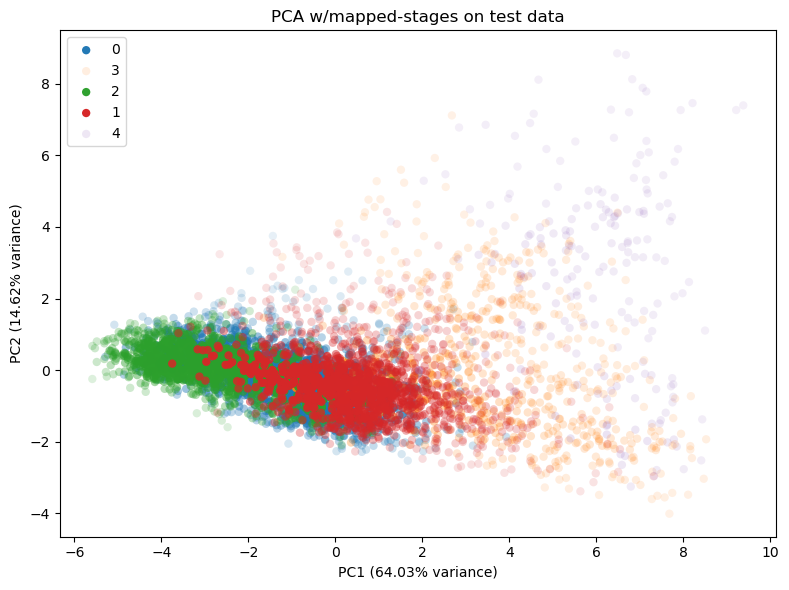

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class Phase_1():
    def __init__(self, data_dir, seed, debug: int = False):
        self.debug = debug
        self.__is_data_built = False
        self.__is_weights = False
        self.__is_sensor_model = False
        self.__is_stage_model = False
        
        self.df, self.X_train, self.X_test, self.scaler = self._build_data_from_dir(data_dir)
        self.weights = self._create_weights()
        if self.debug:
            print(f"[DEBUG] Weights shape: {self.weights.shape}")
        self.sensor_clustering_model = self._sensor_clustering_model(seed)
        self.stage_clustering_model = self._stage_clustering_model(seed)
        
        self.mapping = self._build_mapping()

        print(f"Status: ready")

    def _build_data_from_dir(self, path):
        # Load data as a DataFrame obj
        df = pd.read_csv(data_dir, delimiter=r"\s+")
        df.columns = (
            ["Engine no", "Num cycles", "Operating 1", "Operating 2", "Operating 3"] +
            [f"Sensor {i}" for i in range(df.shape[-1] - 5)]
        )
        train_df = df.drop(
            ["Operating 1", "Operating 2", "Operating 3"] +
            [f"Sensor {i}" for i in [0, 4, 5, 9, 15, 17, 18]],
            axis=1,
            inplace=False
        )
        self.selected_sensors = train_df.keys()[2:].tolist()

        # Create data-splits
        X = train_df.drop(["Engine no", "Num cycles"], axis=1).to_numpy()
        X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)

        
        # Preprocess a lil (standardize)
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)

        self.__is_data_built = True
        return train_df, X_train_std, X_test_std, scaler

    def _create_weights(self):
        correlations = self.df[self.selected_sensors].corrwith(self.df["Num cycles"]).abs()
        weights = correlations / correlations.sum()
        if self.debug:
            print(f"[DEBUG]:\nweights")
        self.__is_weights = True
        return weights.values
    
    def _sensor_clustering_model(self, seed: int):
        assert self.__is_data_built
        model = KMeans(n_clusters=5,max_iter=300,random_state=seed)
        model.fit(self.X_train)
        self.__is_sensor_model = True
        return model

    def _stage_clustering_model(self, seed: int):
        assert self.__is_data_built and self.__is_weights
        scores = self.X_train @ self.weights
        model = KMeans(n_clusters=5, max_iter=300, random_state=seed)
        model.fit(scores.reshape(-1, 1))
        if self.debug:
            print(f"[DEBUG] Stage clustering label distribution: {np.bincount(model.labels_)}")
        self.__is_stage_model = True
        return model

    def _build_mapping(self):
        assert self.__is_data_built and self.__is_weights and self.__is_sensor_model and self.__is_stage_model
        scores = self.X_train @ self.weights
        pred_classes = self.stage_clustering_model.predict(scores.reshape(-1, 1))
        
        unique, counts = np.unique(pred_classes, return_counts=True)
        if self.debug:
            print(f"[DEBUG] unique: {unique} | counts: {counts}")
        
        sorted_cluster_ids = [x for _, x in sorted(zip(counts, unique))]  # ascending by count
        cluster_to_stage = {cluster_id: stage for stage, cluster_id in enumerate(sorted_cluster_ids[::-1])}
        return cluster_to_stage

    def predict(self, x, scale: bool = True):
        x_std = self.scaler.transform(x) if scale else x
        scores = x_std @ self.weights
        raw_stages = self.stage_clustering_model.predict(scores.reshape(-1, 1))
        final_stages = np.array([self.mapping[cls] for cls in raw_stages])
        return final_stages


model = Phase_1(data_dir, 42)
pred_classes = model.predict(model.X_test, False)
plot_pca_2d_density(model.X_test, pred_classes, "PCA w/mapped-stages on test data")

In [59]:
model.mapping

{np.int32(0): 0,
 np.int32(4): 1,
 np.int32(2): 2,
 np.int32(3): 3,
 np.int32(1): 4}

In [60]:
np.unique_counts(pred_classes)

UniqueCountsResult(values=array([0, 1, 2, 3, 4]), counts=array([1393, 1095,  861,  588,  189]))

# Phase-2 start

All things are ready for Phase-2 related work